In [2]:
%%markdown
## Resources
USDA data: https://fdc.nal.usda.gov/download-datasets.html

USDA schema: https://fdc.nal.usda.gov/portal-data/external/dataDictionary

GHG emissions by use: https://ourworldindata.org/food-choice-vs-eating-local

Article on CO2 emissions per calorie: https://academic.oup.com/ajcn/article/101/1/184/4564263

## Resources
USDA data: https://fdc.nal.usda.gov/download-datasets.html

USDA schema: https://fdc.nal.usda.gov/portal-data/external/dataDictionary

GHG emissions by use: https://ourworldindata.org/food-choice-vs-eating-local

Article on CO2 emissions per calorie: https://academic.oup.com/ajcn/article/101/1/184/4564263


In [38]:
import pandas as pd
import numpy as np
import requests
from envs import env
import json
from dataclasses import dataclass

In [6]:
emissions_df = pd.read_csv('./data/ghg/GHG-emissions-by-life-cycle-stage-OurWorldinData-upload.csv')
emissions_df = emissions_df.rename(columns=lambda column: column.replace(' ', '_').lower()).drop(columns='unnamed:_8')
emissions_df

,food_product,land_use_change,animal_feed,farm,processing,transport,packging,retail
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0


In [7]:
df_food = pd.read_csv('./data/usda/food.csv')

In [8]:
df_food_nutrient = pd.read_csv('./data/usda/food_nutrient.csv')
df_nutrient = pd.read_csv('./data/usda/nutrient.csv')
df_nutrient


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,unit_name,nutrient_nbr,rank
0,1002,Nitrogen,G,202.0,500.0
1,1003,Protein,G,203.0,600.0
2,1004,Total lipid (fat),G,204.0,800.0
3,1005,"Carbohydrate, by difference",G,205.0,1110.0
4,1007,Ash,G,207.0,1000.0
...,...,...,...,...,...
227,2025,22:6 c,G,839.0,15250.0
228,2026,20:2 c,G,840.0,14250.0
229,2028,trans-beta-Carotene,UG,321.2,7444.0
230,2029,trans-Lycopene,UG,337.2,7534.0


In [22]:
# create mapping of GHG food groups to FDC IDs
@dataclass
class GHG_FDC_Map:
    ghg_product_name: str
    fdc_id: int
    notes: str = ""

with open('./ghg-fdc-mapping.json', 'r') as f:
    mappings = json.load(f)

GHG_FDC_MAPPING = []
for mapping in mappings:
    if mapping['fdc_id']:
        GHG_FDC_MAPPING.append(GHG_FDC_Map(**mapping))
# GHG_FDC_MAPPING = [
#     GHG_FDC_MAP(
#         ghg_product_name='Wheat & Rye (Bread)', 
#         fdc_id=335240,
#     ),
#     GHG_FDC_MAP(
#         ghg_product_name='Tofu', 
#         fdc_id=391898,
#     ),
#     GHG_FDC_MAP(
#         ghg_product_name='Beef (beef herd)', 
#         fdc_id=746759,
#     ),    
#     GHG_FDC_MAP(
#         ghg_product_name='Eggs', 
#         fdc_id=748967,
#     ),    
#     # 'Maize (Meal)', 
#     # 'Barley (Beer)', 'Oatmeal',
#     #    'Rice', 'Potatoes', 'Cassava', 'Cane Sugar', 'Beet Sugar',
#     #    'Other Pulses', 'Peas', 'Nuts', 'Groundnuts', 'Soymilk', 'Tofu',
#     #    'Soybean Oil', 'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil',
#     #    'Olive Oil', 'Tomatoes', 'Onions & Leeks', 'Root Vegetables',
#     #    'Brassicas', 'Other Vegetables', 'Citrus Fruit', 'Bananas',
#     #    'Apples', 'Berries & Grapes', 'Wine', 'Other Fruit', 'Coffee',
#     #    'Dark Chocolate', 'Beef (beef herd)', 'Beef (dairy herd)',
#     #    'Lamb & Mutton', 'Pig Meat', 'Poultry Meat', 'Milk', 'Cheese',
#     #    'Eggs', 'Fish (farmed)', 'Shrimps (farmed)'
# ]

In [98]:
@dataclass
class Food:
    emissions: pd.DataFrame
    name: str
    nutrients: pd.DataFrame
    combined: pd.DataFrame

@dataclass
class Macro:
    name: str
    g_to_kcal: int
    usda_name: str

food_dicts = []
food_df = None
PROTEIN = 'Protein'
FAT = 'Fat'
CARB = 'Carbohydrate'
MACROS = {
    'Carbohydrate, by difference':
        Macro(
            name=CARB,
            g_to_kcal=4,
            usda_name='Carbohydrate, by difference'
        ),
    'Total lipid (fat)':
        Macro(
            name=FAT,
            g_to_kcal=9,
            usda_name='Total lipid (fat)'
        ),
    'Protein':
        Macro(
            name=PROTEIN,
            g_to_kcal=4,
            usda_name='Protein'
        ),
}
USDA_MACRO_NAMES = MACROS.keys()
EMISSIONS = ['land_use_change','animal_feed','farm','processing','transport', 'packging', 'retail']


def grams_in_100s_to_kg(mass):
    return mass*10

def add_macro_in_kcal(df):

    for macro in USDA_MACRO_NAMES:
        macro_loc = df.nutrient_name == macro
        df.loc[macro_loc, 'nutrient_amount_in_kcal'] = df.loc[macro_loc, 'nutrient_amount_per_kg'] * MACROS[macro].g_to_kcal

    return df

for mapping in GHG_FDC_MAPPING:
    df = df_food.loc[df_food['fdc_id'] == mapping.fdc_id]
    df = pd.merge(df, df_food_nutrient, how='left', on='fdc_id')[['fdc_id', 'description', 'nutrient_id', 'amount']]
    df = pd.merge(df, df_nutrient, left_on='nutrient_id', right_on='id')[['fdc_id', 'description', 'nutrient_id', 'amount', 'name', 'unit_name', 'nutrient_nbr']]

    df['amount'] = grams_in_100s_to_kg(df['amount'])

    df = df.rename(columns={'amount': 'nutrient_amount_per_kg', 'name': 'nutrient_name', 'unit_name': 'nutrient_unit_name'})
    df['product_name'] = mapping.ghg_product_name

    df.to_csv(f'data/artifacts/food-nutrients-{mapping.ghg_product_name}.csv', index=False)
    
    
    nutrients = df.loc[df.nutrient_name.isin(USDA_MACRO_NAMES)]
    total_energy_in_kcal = df.loc[(df.nutrient_name == 'Energy') & (df.nutrient_unit_name == 'KCAL'), 'nutrient_amount_per_kg'].iloc[0]
    nutrients = add_macro_in_kcal(nutrients)
    print(f'total energy: {total_energy_in_kcal}')

    nutrients['nutrient_fraction_of_total_energy'] = nutrients['nutrient_amount_in_kcal'].divide(total_energy_in_kcal)

    print(nutrients['nutrient_fraction_of_total_energy'])

    print(nutrients['nutrient_amount_in_kcal'])
    emissions = emissions_df.loc[emissions_df['food_product'] == mapping.ghg_product_name]

    combined = pd.merge(nutrients, emissions, left_on='product_name', right_on='food_product').drop(columns='food_product')
    combined[EMISSIONS] = combined[EMISSIONS].divide(combined['nutrient_fraction_of_total_energy'], axis=0)

    if food_df is None:
        food_df = combined
    else:
        food_df = pd.concat([food_df, combined])

    food_dict = Food(
        emissions=emissions,
        nutrients=nutrients,
        name=mapping.ghg_product_name,
        combined=combined
    )
    food_dicts.append(food_dict)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [99]:
food_df

,fdc_id,description,nutrient_id,nutrient_amount_per_kg,nutrient_name,nutrient_unit_name,nutrient_nbr,product_name,nutrient_amount_in_kcal,nutrient_fraction_of_total_energy,land_use_change,animal_feed,farm,processing,transport,packging,retail
0,335240,"Bread, whole-wheat, commercially prepared",1004,35.5,Total lipid (fat),G,204.0,Wheat & Rye (Bread),319.5,0.125787,0.794992,0.000000,6.359937,1.589984,0.794992,0.794992,0.794992
1,335240,"Bread, whole-wheat, commercially prepared",1005,431.0,"Carbohydrate, by difference",G,205.0,Wheat & Rye (Bread),1724.0,0.678740,0.147332,0.000000,1.178654,0.294664,0.147332,0.147332,0.147332
2,335240,"Bread, whole-wheat, commercially prepared",1003,123.0,Protein,G,203.0,Wheat & Rye (Bread),492.0,0.193701,0.516260,0.000000,4.130081,1.032520,0.516260,0.516260,0.516260
0,168921,"Corn flour, whole-grain, blue (harina de maiz ...",1003,87.5,Protein,G,203.0,Maize (Meal),350.0,0.096154,3.120000,0.000000,5.200000,1.040000,1.040000,1.040000,0.000000
1,168921,"Corn flour, whole-grain, blue (harina de maiz ...",1004,50.9,Total lipid (fat),G,204.0,Maize (Meal),458.1,0.125852,2.383759,0.000000,3.972932,0.794586,0.794586,0.794586,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,175165,"Fish, catfish, channel, farmed, raw",1003,152.3,Protein,G,203.0,Fish (farmed),609.2,0.511933,0.976691,1.562705,7.032173,0.000000,0.195338,0.195338,0.000000
2,175165,"Fish, catfish, channel, farmed, raw",1005,0.0,"Carbohydrate, by difference",G,205.0,Fish (farmed),0.0,0.000000,inf,inf,inf,NaN,inf,inf,NaN
0,175179,"Crustaceans, shrimp, raw",1004,5.1,Total lipid (fat),G,204.0,Shrimps (farmed),45.9,0.054000,3.703704,46.296296,155.555556,0.000000,3.703704,5.555556,3.703704
1,175179,"Crustaceans, shrimp, raw",1005,0.0,"Carbohydrate, by difference",G,205.0,Shrimps (farmed),0.0,0.000000,inf,inf,inf,NaN,inf,inf,inf


In [100]:
def remove_nans_and_infs(df):
    return df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]


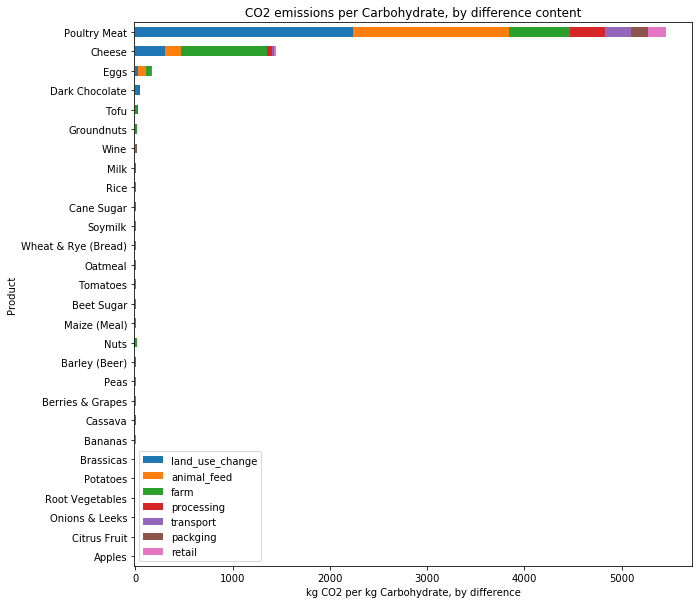

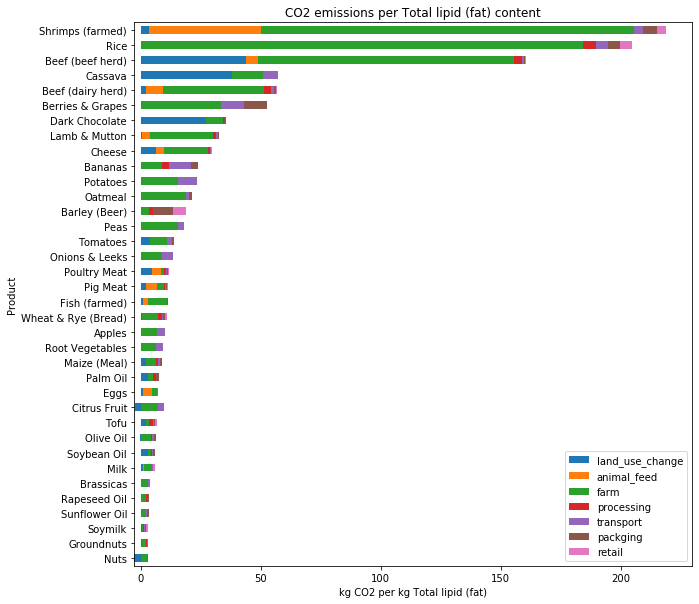

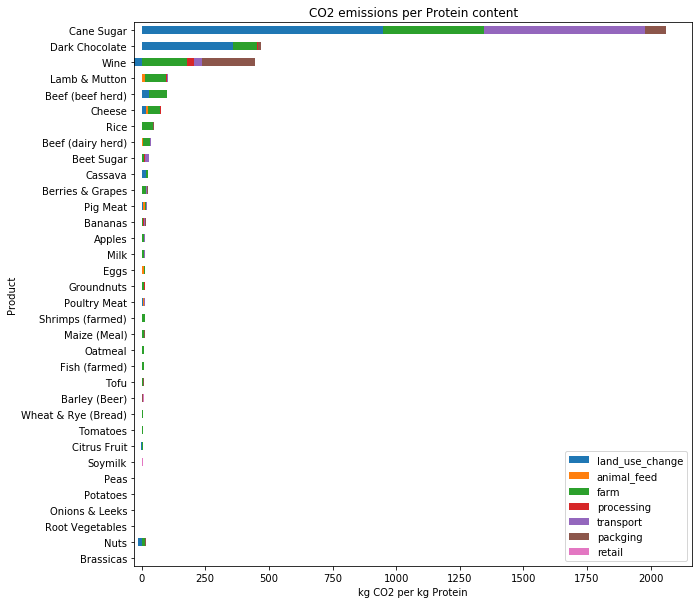

In [101]:
BARS_TO_PLOT = ['product_name', 'land_use_change','animal_feed','farm','processing','transport', 'packging', 'retail']
macros = dict()
for macro in MACROS:
    macros[macro] = food_df.loc[food_df['nutrient_name'] == macro]

    to_plot = macros[macro][BARS_TO_PLOT]
    to_plot = remove_nans_and_infs(to_plot)
    total = to_plot.sum(axis=1)
    to_plot = to_plot.iloc[total.argsort()]

    to_plot = to_plot.set_index('product_name')
    ax = to_plot.plot.barh(stacked=True, title=f'CO2 emissions per {macro} content', figsize=(10, 10), )#xlim=(-0.2, 2.5))
    ax.set_xlabel(f'kg CO2 per kg {macro}')
    ax.set_ylabel('Product')


/opt/conda/lib/python3.7/site-packages/matplotlib/transforms.py:417: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:2179: RuntimeWarning: invalid value encountered in double_scalars
  dx = [convert(x0 + ddx) - x for ddx in dx]
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


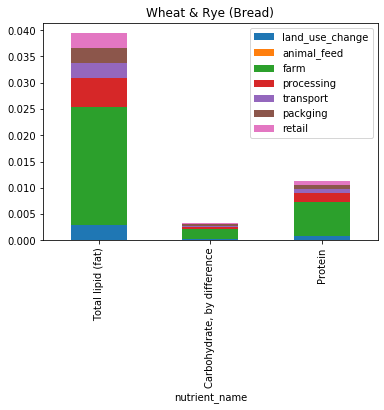

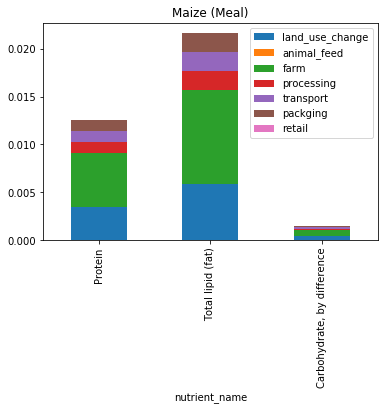

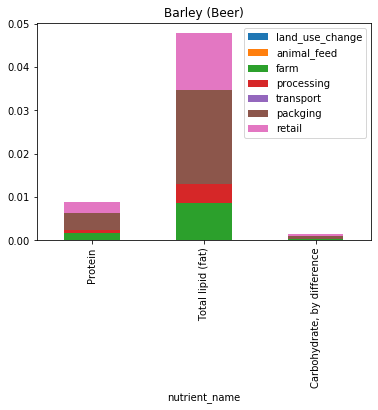

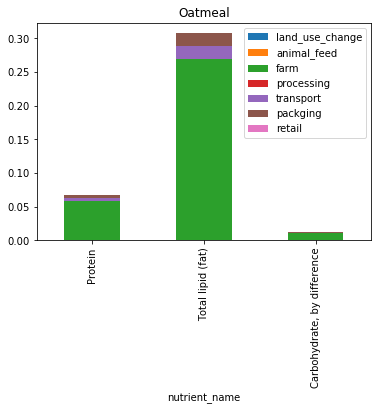

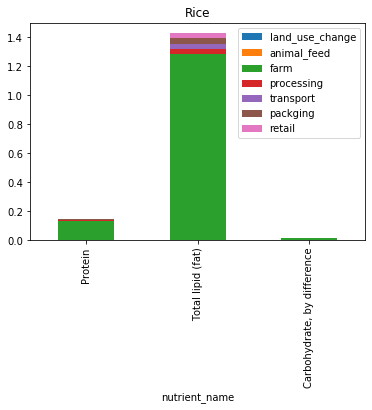

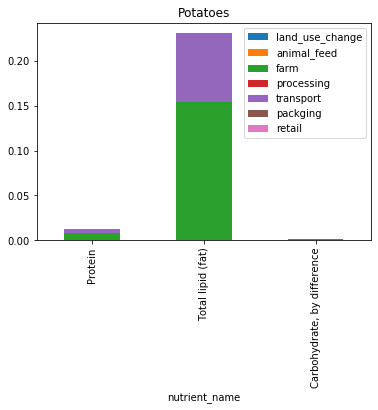

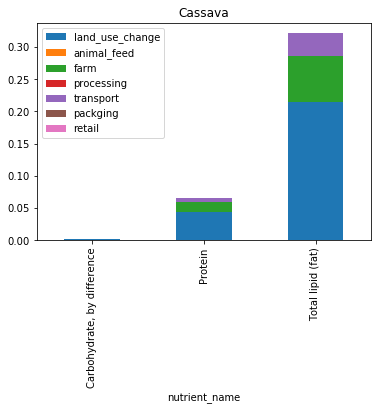

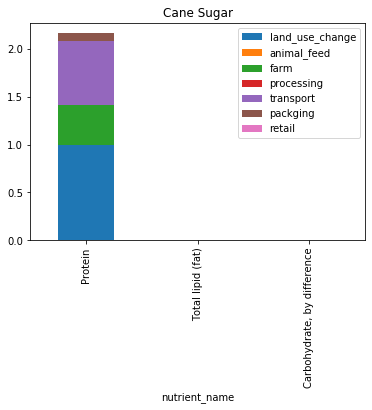

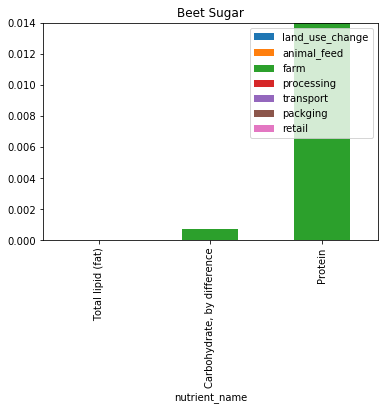

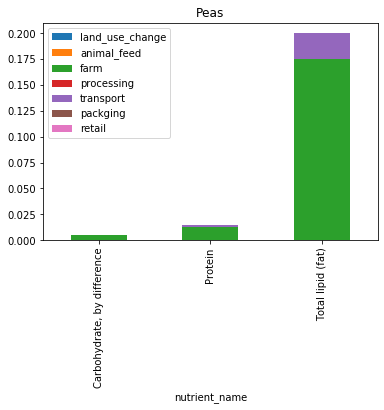

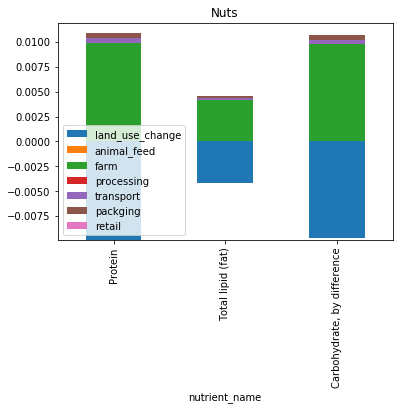

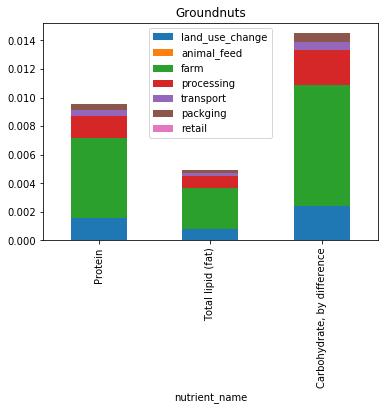

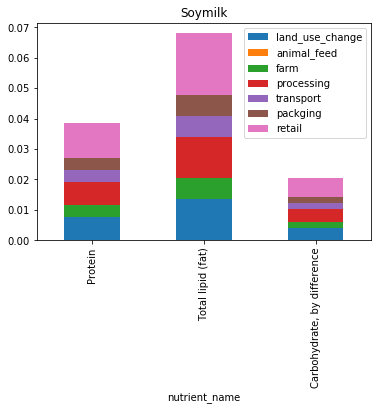

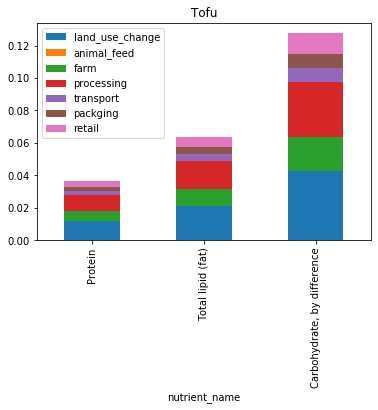

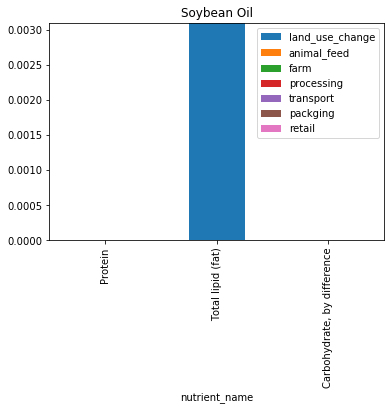

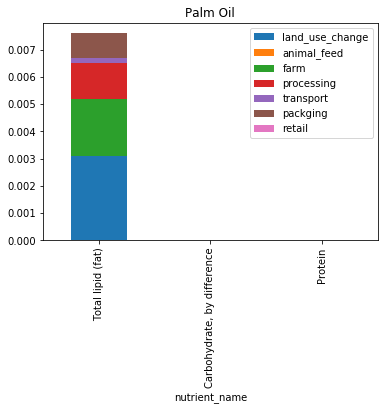

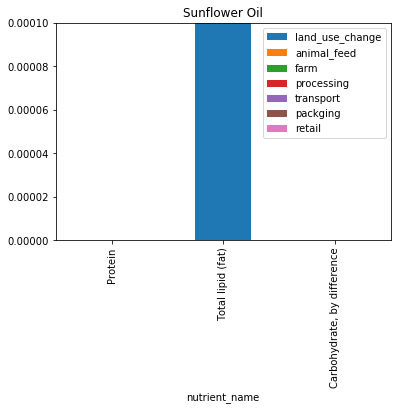

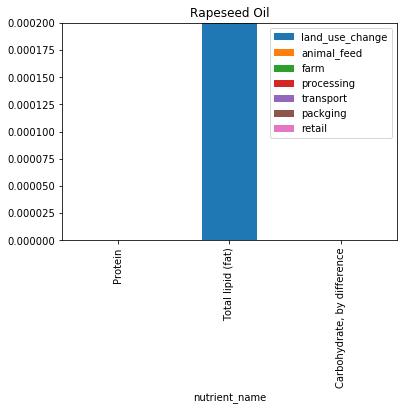

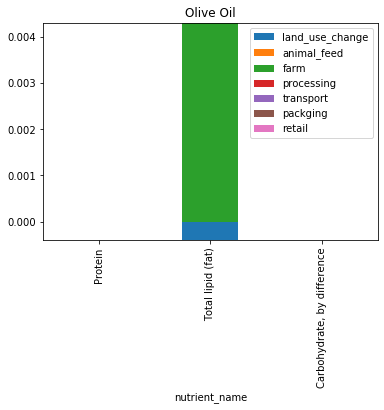

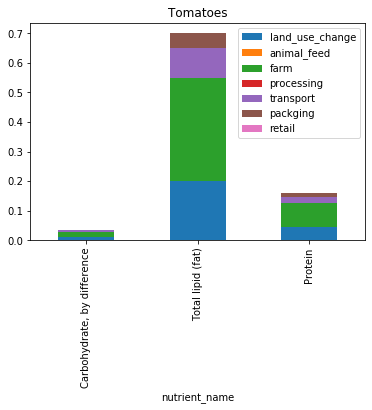

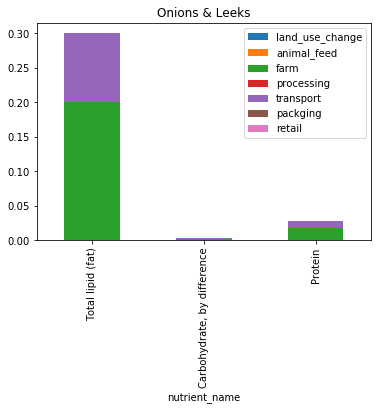

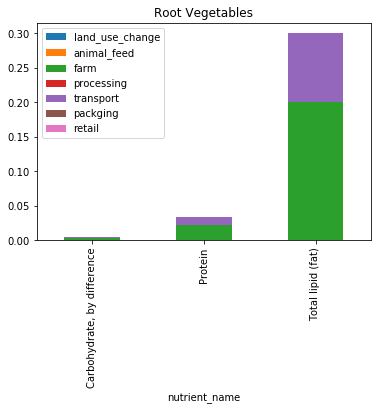

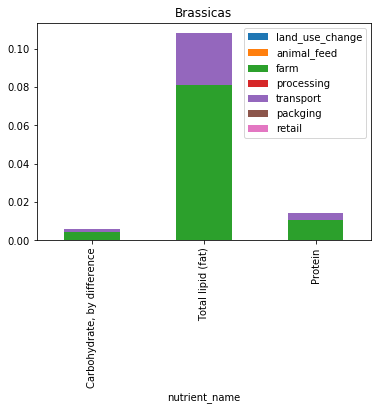

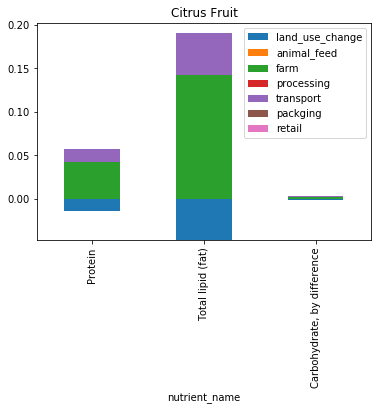

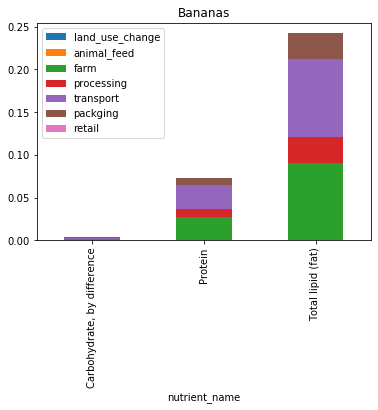

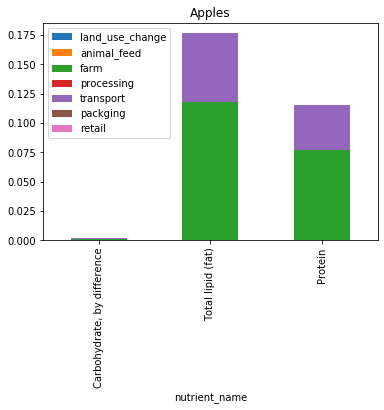

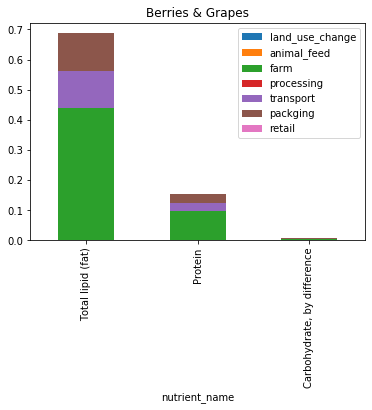

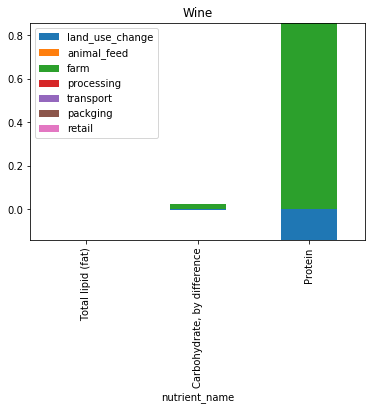

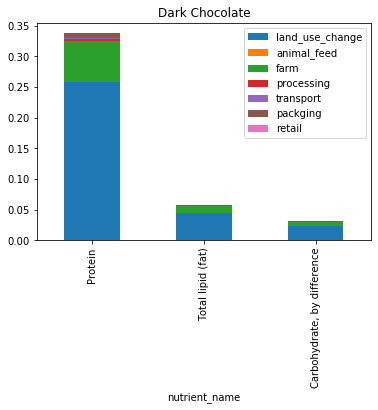

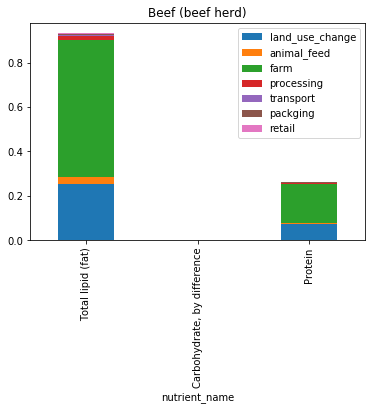

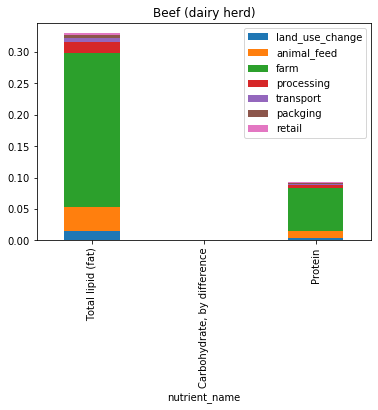

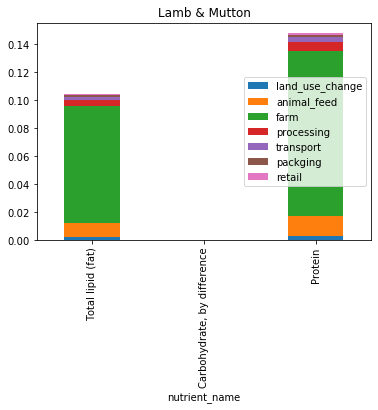

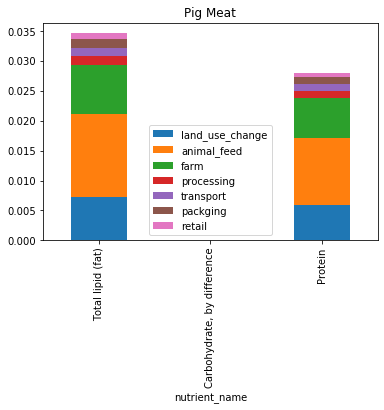

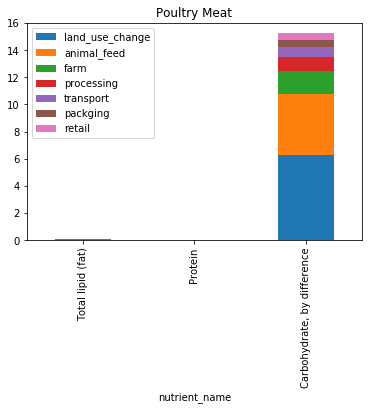

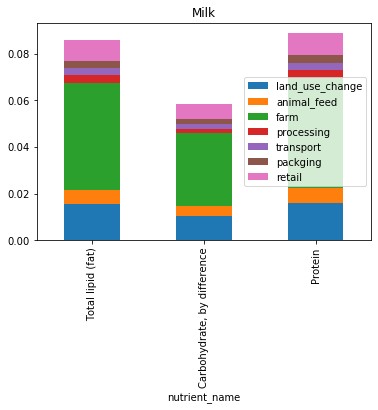

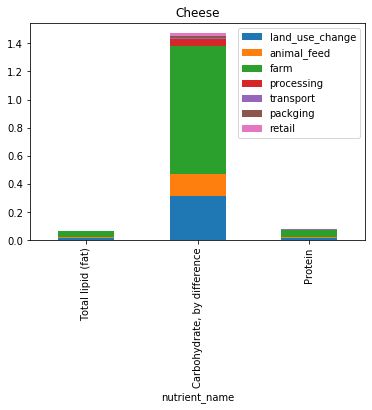

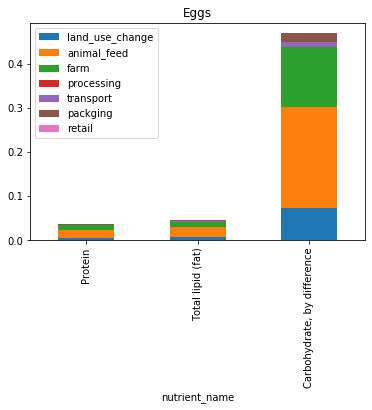

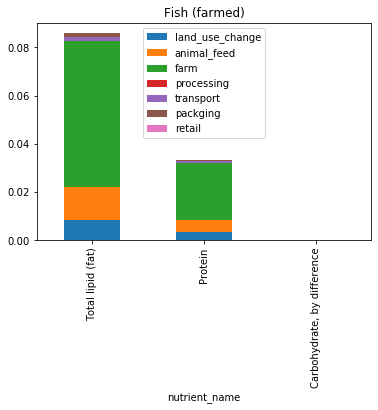

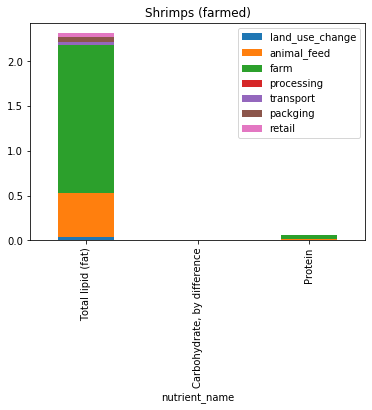

In [44]:
for food in food_dicts:
    to_plot = food.combined[['nutrient_name', 'land_use_change','animal_feed','farm','processing','transport', 'packging', 'retail']]
    
    to_plot = to_plot.set_index('nutrient_name')
    to_plot.plot.bar(stacked=True, title=food.name,)